<a href="https://colab.research.google.com/github/JedRoundy/Predictive_Learning/blob/main/Final_Project_455.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This project accesses the Ebay API, searches for smartphones. It then sorts through the text to find attributes such as brand, and quality.
# It also pulls listing attributes from the Ebay API. It then uses kfolds to predict prices.

In [ ]:
#Import Necessary packages

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/')  # Replace 'Your_Directory' with your desired directory path


#Getting Data from ebay
import pandas as pd
import numpy as np
import requests
import os
import json
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

#Sentiment
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

#Cleaning / Standardizing
from sklearn.preprocessing import StandardScaler
import missingno as msn
import math

#Multiple Regresssion
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from datetime import datetime as dt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Hierarchal Clustering
!pip install gower
import gower
from sklearn.cluster import AgglomerativeClustering


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Getting Data

In [ ]:
#establish credentials (please don't steal these)

app_id = "JedRound-FinalPro-PRD-d523606ce-61a42171"
cert_id = "PRD-523606ce2da5-a6ad-4176-8632-d3e4"
auth_token = "v^1.1#i^1#f^0#I^3#p^3#r^1#t^Ul4xMF85OjVCODgxOTE1REQ2RTJDMDgxNUIyN0I4MkMxRUVBQUQ5XzNfMSNFXjI2MA=="
dev_name = 'b42c6ce2-b470-4366-803c-005fd6b3e47e'

In [ ]:
##Get the Primary data and clean it

In [ ]:

def get_items(app_id, keyword, page_num = 1):
  #identify api url and payload
  url = 'https://svcs.ebay.com/services/search/FindingService/v1'
  payload = {
      'OPERATION-NAME': 'findItemsAdvanced',
      'SERVICE-VERSION': '1.13.0',
      'SECURITY-APPNAME': app_id,
      'RESPONSE-DATA-FORMAT': 'JSON',
      'keywords': keyword,
      'paginationInput': {
          'entriesPerPage': '100',
          'pageNumber': 1
      },
      'outputSelector': ['SellerInfo', 'Title', 'Description']
  }

  response = requests.get(url, params=payload)
  data = response.json()

  items = data['findItemsAdvancedResponse'][0]['searchResult'][0]['item']


  #create lists for dataframe
  id_list = []
  title_list = []
  url_list = []
  current_price_list = []
  status_list = []
  condition_list = []
  shipping_cost_list = []
  shipping_type_list = []
  listing_type_list = []


  # Store details about each item in a list
  for item in items:
      id_list.append(item['itemId'][0])
      title_list.append(item['title'][0])
      url_list.append(item['galleryURL'][0])
      current_price_list.append(item['sellingStatus'][0]['currentPrice'][0]['__value__'])
      status_list.append(item['sellingStatus'][0]['sellingState'][0])
      condition_list.append(item['condition'][0]['conditionDisplayName'][0])
      try:
        shipping_cost_list.append(item['shippingInfo'][0]['shippingServiceCost'][0]['__value__'])
      except:
        shipping_cost_list.append(None)
      shipping_type_list.append(item['shippingInfo'][0]['shippingType'][0])
      listing_type_list.append(item['listingInfo'][0]['listingType'][0])


  items_list = zip(id_list, title_list, current_price_list, condition_list, status_list, shipping_cost_list, shipping_type_list, listing_type_list, url_list)

  return items_list

In [ ]:
main_df = pd.DataFrame(data = None, columns = ['Listing ID', 'Title', 'Current Price', 'Condition', 'Status', 'Shipping Cost' ,'Shipping Type', 'Listing Type', 'Gallery URL'])
id_list = []
keyword_list = ['iphone', 'smartphone', 'phone', 'cell phone', 'apple phone', 'samsung phone', 'google phone', 'pixel phone', 'smart phone' ,'i phone' ,'samsung galaxy phone', 'samsung note phone', 'galaxy z phone', 'galaxy z flip phone', 'galaxy z fold phone', 'iphone 10', 'iphone 11', 'iphone 12' ,'iphone 13' ,'iphone 14', 'iphone max', 'iphone mini', 'iphone pro']

for keyword in keyword_list:

    #create a main_df list and and id_list
    df_list = get_items(app_id, keyword)

    #Create new df from data of most recent api call
    temp_df = pd.DataFrame(data = df_list, columns = ['Listing ID', 'Title', 'Current Price', 'Condition', 'Status', 'Shipping Cost' ,'Shipping Type', 'Listing Type', 'Gallery URL'])

    # merge the new one with the main one
    main_df = pd.concat([main_df, temp_df], ignore_index = True)

In [ ]:
#Check for duplicate data and drop it
main_df.drop_duplicates(inplace = True)

#Set the listing id to an int
main_df['Listing ID'] = main_df['Listing ID'].astype(int)

#Set the Listing ID to the index
main_df.set_index('Listing ID', inplace = True)





In [ ]:

#create an id list from the modified
temp_id_list = main_df.index.tolist()


#format the id_list to ints for future use
id_list = [int(num) for num in temp_id_list]



In [ ]:
### GET THE SECONDARY DATA AND CLEAN IT


In [ ]:

def get_item_details(id, app_id, cert_id, auth_token, dev_name, df_dict):
  # Set up API credentials and endpoint URL
  url = "https://api.ebay.com/ws/api.dll"

  # Set up request headers
  headers = {
      "X-EBAY-API-CALL-NAME": "GetItem",
      "X-EBAY-API-APP-ID": app_id,
      "X-EBAY-API-CERT-NAME": cert_id,
      "X-EBAY-API-DEV-NAME": dev_name,
      "X-EBAY-API-SITEID": "0",
      "X-EBAY-API-COMPATIBILITY-LEVEL": "1145",
      "X-EBAY-API-IAF-TOKEN": auth_token,
      "X-EBAY-API-IAF-TOKEN": "JSON",
      "Content-Type": "text/xml"
  }

  # Set up request body
  body = f"""<?xml version="1.0" encoding="utf-8"?>
  <GetItemRequest xmlns="urn:ebay:apis:eBLBaseComponents">
      <RequesterCredentials>
          <eBayAuthToken>{auth_token}</eBayAuthToken>
      </RequesterCredentials>
      <ItemID>{id}</ItemID>
      <IncludeItemSpecifics>true</IncludeItemSpecifics>
      <IncludeWatchCount>true</IncludeWatchCount>
      <DetailLevel>ReturnAll</DetailLevel>
  </GetItemRequest>
  """

  # Send API request and parse response JSON
  response = requests.post(url, headers=headers, data=body)

  # extract the data from the xml text
  root = ET.fromstring(response.text)
  ns = {'eBay': 'urn:ebay:apis:eBLBaseComponents'}



  details_list = []

  # Find the elements
  details_list.append(root.find('.//{urn:ebay:apis:eBLBaseComponents}HasUnansweredQuestions').text)
  details_list.append(root.find('.//{urn:ebay:apis:eBLBaseComponents}BuyerProtection').text)
  details_list.append(root.find('.//{urn:ebay:apis:eBLBaseComponents}PositiveFeedbackPercent').text)

  #return policy elements
  return_policy_element = root.find('.//{urn:ebay:apis:eBLBaseComponents}ReturnPolicy')
  try:
    details_list.append(return_policy_element.find('.//{urn:ebay:apis:eBLBaseComponents}ReturnsAccepted').text)
  except:
    details_list.append(None)
  try:
    details_list.append(return_policy_element.find('.//{urn:ebay:apis:eBLBaseComponents}ReturnsWithin').text)
  except:
    details_list.append(None)
  try:
    details_list.append(return_policy_element.find('.//{urn:ebay:apis:eBLBaseComponents}Refund').text)
  except:
    details_list.append(None)
  try:
    details_list.append(return_policy_element.find('.//{urn:ebay:apis:eBLBaseComponents}ShippingCostPaidByOption').text)
  except:
    details_list.append(None)


  #establish the key as the id of the product and the value of the list of attributes
  key = id
  value = details_list

  #update the dictionary and return it for the next iteration
  details_dict.update({key : value})

  return details_dict


In [ ]:
#Create a dictionary that adds another key:value pair for each listing id in the primary item request.



details_dict = {}

for id in id_list:

  details_dict = get_item_details(id, app_id, cert_id, auth_token, dev_name, details_dict)


#Create a dataframe from the dictionary

df_details = pd.DataFrame.from_dict(details_dict, orient = 'index', columns = ['Unanswered Questions', 'Buyer Protection', 'Positive Feedback Percent', 'Returns Accepted', 'Returns Within', 'Refund' ,'Shipping Cost Paid By'])

df_details


,Unanswered Questions,Buyer Protection,Positive Feedback Percent,Returns Accepted,Returns Within,Refund,Shipping Cost Paid By
354593750415,true,ItemIneligible,98.3,Returns Accepted,30 Days,Money Back,Seller
265620291838,true,ItemIneligible,96.9,Returns Accepted,30 Days,Money back or replacement (buyer's choice),Seller
354593664182,true,ItemIneligible,98.3,Returns Accepted,30 Days,Money Back,Seller
114408133790,true,ItemIneligible,99.2,Returns Accepted,30 Days,Money Back,Seller
195588785601,true,ItemIneligible,98.0,Returns Accepted,30 Days,Money back or replacement (buyer's choice),Seller
...,...,...,...,...,...,...,...
314376496080,true,ItemIneligible,97.6,Returns Accepted,30 Days,Money Back,Seller
304160998712,true,ItemIneligible,99.1,Returns Accepted,60 Days,Money back or replacement (buyer's choice),Seller
284503141857,true,ItemIneligible,98.9,Returns Accepted,30 Days,Money Back,Seller
363215088240,true,ItemIneligible,99.2,Returns Accepted,60 Days,Money back or replacement (buyer's choice),Seller


In [ ]:
#Merge the two Dataframes

df = pd.merge(main_df, df_details, left_index = True, right_index = True, indicator = True)

#drop duplicate listing ID's
df = df[~df.index.duplicated(keep='first')]


#Cleaning Data

In [ ]:
#Unfortunately, some listing for phone covers / cases are included in our summary. Let's get rid of them

conditions = [' cover', 'case', 'stand', 'charger', 'protect']

for index, title in df['Title'].iteritems():
  title = title.lower()

  if any(condition in title for condition in conditions):
    df.drop(index, inplace = True)


<ipython-input-12-2fde4307a499>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, title in df['Title'].iteritems():


In [ ]:
##Text Analytics for Description
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

sentiment_list = []
for row in df['Title']:
  if row is not None:
    sentiment_list.append(sia.polarity_scores(row)['compound'])
  else:
    sentiment_list.append(None)


df['Sentiment'] = sentiment_list

df['Sentiment'].value_counts()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


 0.0000    301
 0.4927    100
 0.4404     72
 0.5719     43
 0.3182     10
 0.6633      9
 0.5622      8
 0.6249      6
 0.0516      4
-0.5423      4
 0.6867      4
-0.6408      3
-0.4404      2
 0.6932      2
 0.4877      2
-0.2960      2
 0.5574      2
 0.4019      2
 0.3802      1
 0.6028      1
 0.7755      1
 0.7351      1
 0.7034      1
 0.4902      1
 0.2263      1
 0.6166      1
 0.5319      1
 0.5106      1
 0.4939      1
 0.4648      1
-0.5622      1
 0.6588      1
 0.2484      1
-0.4939      1
 0.0258      1
 0.5356      1
 0.7723      1
Name: Sentiment, dtype: int64

In [ ]:
#Create a brand column
brand_list = []

for title in df['Title']:

  title = title.lower()

  #Find Apple Phones
  if (title.find('apple')) > -1:
    brand_list.append('Apple')

  elif (title.find('iphone')) > -1:
    brand_list.append('Apple')

  #Find samsung phones
  elif (title.find('samsung')) > -1:
    brand_list.append('Samsung')

  elif (title.find('galaxy')) > -1:
    brand_list.append('Samsung')

  #Find Google Phones
  elif (title.find('google') | title.find('pixel')) > -1:
    brand_list.append('Google')
  #Anything not identified is 'Other'
  else:
    brand_list.append('Other')

#append brand list to the dataframe
df['Brand'] = brand_list



In [ ]:
#Change values to correct dtypes
df['Shipping Cost'] = df['Shipping Cost'].astype(float)
df['Current Price'] = df['Current Price'].astype(float)
df['Positive Feedback Percent'] = df['Positive Feedback Percent'].astype(float)


<Axes: xlabel='Log Current Price', ylabel='Count'>

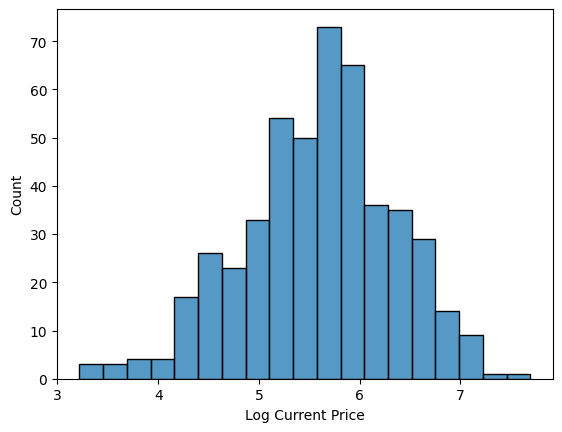

In [ ]:
#Check for Label Skewness

#Before checking for skewness, I want to eliminate all rows that are not Fixed Price because they create a weird skew and the prices aren't meaningful to predict as they will change anyway.
df = df.loc[df['Listing Type'] == 'FixedPrice']
#I also don't want to predict prices for phones that are broken or just being sold for parts.
df = df.loc[df['Condition'] != 'For parts or not working']

df['Log Current Price'] = np.log(df['Current Price'])

df['Log Current Price'].skew()

sns.histplot(df['Log Current Price'])

In [ ]:
#Binning Rare Values

#After looking at the data, it is clear that these values will need to be regularly binned.
#All other columns have only 3 groups where 1 is regularly an outlier and thus no purpose in binning them as it would only bias other groups


df['Shipping Type'].loc[(df['Shipping Type'] == 'FreePickup') | (df['Shipping Type'] == 'FlatDomesticCalculatedInternational')] = 'Other'




<ipython-input-17-3767dcadee2c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Shipping Type'].loc[(df['Shipping Type'] == 'FreePickup') | (df['Shipping Type'] == 'FlatDomesticCalculatedInternational')] = 'Other'


In [ ]:
#Replaced missing values with Mode.


#Data with missing values are because the Returns Accepted column is 'No returns accepted' and just leaves the rest of the values null.
#Thus, it doesn't make sense to replace them with a prediction, mean, median, or mode.
#I'll simply replace it with 'No Returns'
df['Returns Within'].loc[df['Returns Accepted'] == 'No returns accepted'] = 'No Returns'
df['Refund'].loc[df['Returns Accepted'] == 'No returns accepted'] = 'No Returns'
df['Shipping Cost Paid By'].loc[df['Returns Accepted'] == 'No returns accepted'] = 'No Returns'

df.loc[df['Returns Accepted'] == 'No returns accepted']


#All of the Nan's were due to the shipping cost being calculated, so I replaced the missing values with the same value as 'Shipping Type'
df.loc[df['Shipping Type'] == 'Calculated', 'Shipping Cost'] = 'Calculated'

<ipython-input-18-88ab81da7841>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Returns Within'].loc[df['Returns Accepted'] == 'No returns accepted'] = 'No Returns'
<ipython-input-18-88ab81da7841>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Refund'].loc[df['Returns Accepted'] == 'No returns accepted'] = 'No Returns'
<ipython-input-18-88ab81da7841>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Shipping Cost Paid By'

In [ ]:
#Download a .csv from cleaning the data

df.to_csv('ebay_data.csv', index = False)

#Multiple Regression

In [ ]:
#Create copy of original df to manipulate for predictin purposes
predict_df = df.copy()

#Remove irrelevant columns for prediction.
predict_df.drop(columns = ['Gallery URL', '_merge'], inplace = True)

#Get dummies
dummy_cols = predict_df.select_dtypes(include = ['object'])

#I don't want to get dummies for these because I will drop them later anyway.
dummy_cols.drop(columns = ['Shipping Cost', 'Title'], inplace = True)

#Get dummies and drop the first column.
dummy_df = pd.get_dummies(dummy_cols, drop_first = True)

#Drop the dummy cols from predict_df
predict_dropped_dummies_df = predict_df.drop(columns = dummy_cols.columns)

#Drop columns that are no good for mlr. Shipping cost has mixed dtypes and Title already has sentiment score and would result in too many dummies.
mlr_df = pd.merge(dummy_df, predict_dropped_dummies_df, left_index = True, right_index = True)

#Drop shipping cost and title
mlr_df.drop(columns = ['Shipping Cost', 'Title'], inplace = True)


In [ ]:
# Identify y and x

y = mlr_df['Log Current Price']
x = mlr_df.drop(columns = ['Current Price', 'Log Current Price'])
x = sm.add_constant(x)

#Create the model
model = sm.OLS(y, x)

#Fit the model
results = model.fit()

#Print the results summary
print(results.summary())

mlr_prediction  = mlr_df.copy()

mlr_prediction['Predicted Log Price'] = results.predict(x)


                            OLS Regression Results                            
Dep. Variable:      Log Current Price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     20.21
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           4.57e-54
Time:                        16:20:47   Log-Likelihood:                -379.63
No. Observations:                 480   AIC:                             805.3
Df Residuals:                     457   BIC:                             901.3
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [ ]:
###Improve the Regression Functions

def print_metrics(results, df, prediction_df):
  R_Squared = results.rsquared
  R_Squared_Adj = results.rsquared_adj
  RMSE = mean_squared_error(df['Log Current Price'], prediction_df['Price Prediction'], squared = False)
  MAE = mean_absolute_error(df['Log Current Price'], prediction_df['Price Prediction'])
  label_mean = math.exp(df['Log Current Price'].mean())
  predict_label_mean = math.exp(prediction_df['Price Prediction'].mean())
  print(f'R-Squared: {R_Squared}')
  print(f'R_Squared_Adj: {R_Squared_Adj}\n')

  print(f'RMSE: {RMSE}')
  print(f'MAE: {MAE}\n')

  print(f'Log Price Mean: {label_mean}')
  print(f'Predicted Log Price Mean: {predict_label_mean}')

  return None


##Begin to remove unnecessary variables

#Create list of p-values
def get_p_values(results):
  p_values = results.pvalues.tolist()
  p_values.pop(0)
  return p_values


def get_drop_var(vars, p_values):
  #Create df to store p values by variable
  df = pd.DataFrame({'p_val': p_values, 'variables': vars})
  #sort values from high to low, apply to df
  df = df.sort_values(by = ['p_val'], ascending = False).reset_index()
  #drop the new index created, apply to df
  df.drop(columns = ['index'], inplace = True)

  return df['variables'][0]

#Get rsq - rsqd_aj
def get_r_diff(results):
  #calculate r_score
  R_diff = results.rsquared - results.rsquared_adj
  #return relevant variables
  return R_diff

#Create inital list of variable names
def get_vars(x):
  #vars = x.drop(columns = ['const'])
  vars = x.columns.tolist()
  vars.pop(0)
  return vars

#create streamlined process to get MLR results
def get_results(x, y, drop_var):
  try:
    x.drop(columns = drop_var, axis = 1, inplace = True)
  except:
    None
  results = sm.OLS(y,x).fit()
  return results, x


In [ ]:
#Re-establish x and y
y = mlr_df['Log Current Price']
x = mlr_df.drop(columns = ['Current Price', 'Log Current Price'])
x = sm.add_constant(x)


In [ ]:
#Loop to get rid of high p values if Rsq - Rsqadj > .01

r_diff = 1
drop_var = ''
while r_diff > .01:
  #Get OLS results
  results, x  = get_results(x, y, drop_var)

  #Get R_diff
  r_diff = get_r_diff(results)

  #Get p_values
  p_values = get_p_values(results)

  #Get variable names for most recent iteration of the loop
  vars = get_vars(x)

  #Get the least significant variable
  drop_var = get_drop_var(vars, p_values)



In [ ]:
#With a smaller dataset, rerun OLS

model = sm.OLS(y,x)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Log Current Price   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     48.34
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           1.03e-56
Time:                        16:20:48   Log-Likelihood:                -398.83
No. Observations:                 480   AIC:                             815.7
Df Residuals:                     471   BIC:                             853.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [ ]:
#Look at the details of the regression metrics
mlr_prediction.drop(columns = 'Predicted Log Price', inplace = True)

mlr_prediction['Price Prediction'] = results.predict(x)

print_metrics(results, mlr_df, mlr_prediction)

R-Squared: 0.45086166391694305
R_Squared_Adj: 0.4415344734951502

RMSE: 0.5554103178030256
MAE: 0.43624483958885635

Log Price Mean: 270.7186233881506
Predicted Log Price Mean: 270.71862338815424


In [ ]:
#Standardizing at this point is nearly meaningless because I only have one numeric predictor

#Clustering

In [ ]:
#Create a clustering df
c_df = df.copy()

In [ ]:
#Drop unecessary columns and label
c_df.drop(columns = ['Title', 'Log Current Price', '_merge', 'Gallery URL'], inplace = True)

In [ ]:
#Create a gower matrix df

distance_matrix = gower.gower_matrix(c_df)
pd.DataFrame(distance_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
0,0.000000,0.204467,0.032252,0.000774,0.026668,0.004337,0.244229,0.251590,0.221023,0.304245,...,0.234606,0.075824,0.135855,0.136378,0.138989,0.139542,0.293224,0.203825,0.203402,0.233254
1,0.204467,0.000000,0.228318,0.203693,0.222734,0.200137,0.106428,0.113789,0.157441,0.166444,...,0.231206,0.205757,0.139145,0.138623,0.136011,0.136142,0.227761,0.000909,0.274535,0.296520
2,0.032252,0.228318,0.000000,0.031745,0.005584,0.028181,0.211977,0.219338,0.211762,0.271993,...,0.207228,0.098297,0.166930,0.166408,0.163796,0.163243,0.272362,0.228694,0.235654,0.203071
3,0.000774,0.203693,0.031745,0.000000,0.026161,0.003564,0.243455,0.250816,0.220681,0.303471,...,0.234633,0.075851,0.135882,0.136404,0.139015,0.139568,0.293250,0.203851,0.204175,0.233280
4,0.026668,0.222734,0.005584,0.026161,0.000000,0.022597,0.217561,0.224922,0.206178,0.277577,...,0.208472,0.094249,0.161346,0.160824,0.158212,0.157966,0.272069,0.223110,0.230070,0.207119


In [ ]:
#Use the average clustering method. Unfortunately right now it clusters on only 1 item using price, but if I cluster other ways it just clusters on if returns are accepted or not.
agg = AgglomerativeClustering(affinity="precomputed", linkage="average").fit(distance_matrix)
c_df['agg_cluster'] = agg.labels_

#Show clustering df

c_df

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,Current Price,Condition,Status,Shipping Cost,Shipping Type,Listing Type,Unanswered Questions,Buyer Protection,Positive Feedback Percent,Returns Accepted,Returns Within,Refund,Shipping Cost Paid By,Sentiment,Brand,agg_cluster
114408133790,79.84,Used,Active,0.0,Free,FixedPrice,true,ItemIneligible,99.2,Returns Accepted,30 Days,Money Back,Seller,0.0000,Apple,0
114789287210,207.88,Open box,Active,0.0,Free,FixedPrice,true,ItemIneligible,100.0,Returns Accepted,30 Days,Money back or replacement (buyer's choice),Seller,0.0000,Samsung,0
114974289190,239.00,Used,Active,0.0,Free,FixedPrice,true,ItemIneligible,99.6,Returns Accepted,30 Days,Money Back,Seller,0.5356,Apple,0
114996232299,92.00,Used,Active,0.0,Free,FixedPrice,true,ItemIneligible,99.8,Returns Accepted,30 Days,Money Back,Seller,0.0000,Apple,0
115373485590,214.00,Used,Active,0.0,Free,FixedPrice,true,ItemIneligible,99.6,Returns Accepted,30 Days,Money Back,Seller,0.4404,Apple,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404069171377,219.00,Good - Refurbished,Active,0.0,Free,FixedPrice,true,ItemIneligible,96.3,Returns Accepted,30 Days,Money Back,Seller,0.0000,Samsung,0
404124301113,132.95,Very Good - Refurbished,Active,0.0,Free,FixedPrice,true,ItemIneligible,99.2,Returns Accepted,60 Days,Money back or replacement (buyer's choice),Seller,0.4927,Google,0
404179900024,199.99,Open box,Active,0.0,Free,FixedPrice,true,ItemIneligible,99.0,Returns Accepted,30 Days,Money back or replacement (buyer's choice),Seller,0.0000,Samsung,0
404236691989,40.72,New,Active,0.0,Free,FixedPrice,true,ItemIneligible,95.9,Returns Accepted,30 Days,Money Back,Buyer,0.0000,Other,0


#Automation

In [ ]:
##Automation packages

from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from numpy import mean, std
import joblib
import sklearn.linear_model as lm, pandas as pd
from sklearn.model_selection import KFold, cross_val_score
import sklearn.neural_network as nn
#tuning hyper parameters
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [ ]:
#Create new df for automation
auto_df = mlr_df.copy()
auto_df.drop(columns = 'Current Price', inplace = True)

In [ ]:
#Feature Selection
label = 'Log Current Price'

def feature_selection(df, label, p = .9):
  if label != "":
    X = auto_df.drop(columns=[label])

  sel = VarianceThreshold(threshold=(p * (1 - p)))
  sel.fit_transform(X)

  # Add the label back in after removing poor features
  return df[sel.get_feature_names_out()].join(df[label])

auto_df = feature_selection(auto_df, 'Log Current Price')


In [ ]:
def dump_joblib(model, file_name):
  joblib.dump(model, file_name)

def load_joblib(file_name):
  model = joblib.load(file_name)
  return model

In [ ]:
#Regression Algorithms


fit = {}    # Use this to store each of the fit metrics
models = {} # Use this to store each of the models

# Set up a standard cross_validation object to use for each algorithm
cv = KFold(n_splits=5, random_state=12345, shuffle=True)


def select_model(df, label, k = 10, r = 5, repeat = True):

  if repeat:
    cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=12345)
  else:
    cv = KFold(n_splits=k, random_state=12345, shuffle=True)

  x = df.drop(columns = label)
  y = df[label]

  # Bayesian
  model_br = lm.BayesianRidge()
  fit['Bayesian'] = mean(cross_val_score(model_br, x, y, scoring='r2', cv=cv, n_jobs=-1))
  models['Bayesian'] = model_br

  # OLS
  model_ols = lm.LinearRegression()
  fit['OLS'] = mean(cross_val_score(model_ols, x, y, scoring='r2', cv=cv, n_jobs=-1))
  models['OLS'] = model_ols


  # Ridge
  ridge_model = Ridge()

  params = {'alpha': [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}
  # Create the hypertuning search object
  model_ridge = GridSearchCV(
    ridge_model,
    params,
    n_jobs=-1,
    scoring='r2',
    cv=KFold(n_splits=3),
    verbose=3,
    refit=True
    )

  fit_ridge = model_ridge.fit(x,y)
  fit['Ridge'] = fit_ridge.best_score_
  models['Ridge'] = model_ridge


  # Lasso Regression
  lasso_model = Lasso()

  model_lr = GridSearchCV(
      lasso_model,
      params,
      n_jobs = -1,
      scoring = 'r2',
      cv = KFold(n_splits = 3),
      verbose = 3,
      refit = True
  )
  fit_lasso = model_lr.fit(x,y)
  fit['Lasso'] = fit_lasso.best_score_
  models['Lasso'] = model_lr



  # MLP
  params = {'max_iter': [100, 500, 1000, 1500, 2500], 'random_state': [12345, 123]}

  model_nn = GridSearchCV(
      nn.MLPRegressor(),
      params,
      n_jobs = -1,
      scoring = 'r2',
      cv = KFold(n_splits = 3),
      refit = True
  )
  fit_nn = model_nn.fit(x,y)
  fit['NeuralNet'] = fit_nn.best_score_
  models['NeuralNet'] = model_nn


  # Add the fit dictionary to a new DataFrame, sort, extract the top row, use it to retrieve the model object from the models dictionary
  df_fit = pd.DataFrame({'R-squared':fit})
  df_fit.sort_values(by=['R-squared'], ascending=False, inplace=True)
  best_model = df_fit.index[0]

  return models[best_model].fit(x, y)


In [ ]:
model = select_model(auto_df, 'Log Current Price')

#save and deploy
dump_joblib(model, '/content/drive/MyDrive/Colab Notebooksbest_model.sav')

#predict
model.predict(auto_df.drop(columns=['Log Current Price']))


Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits


array([5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107999,
       5.60107999, 5.60107999, 5.60107999, 5.60107999, 5.60107